In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# First row 'Measurement'
first_row_m = session.query(Measurement).first()
first_row_m.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f9e20c8eb80>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1}

In [10]:
# First row 'Station'
first_row_s = session.query(Station).first()
first_row_s.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f9e20c9ea00>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'id': 1,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

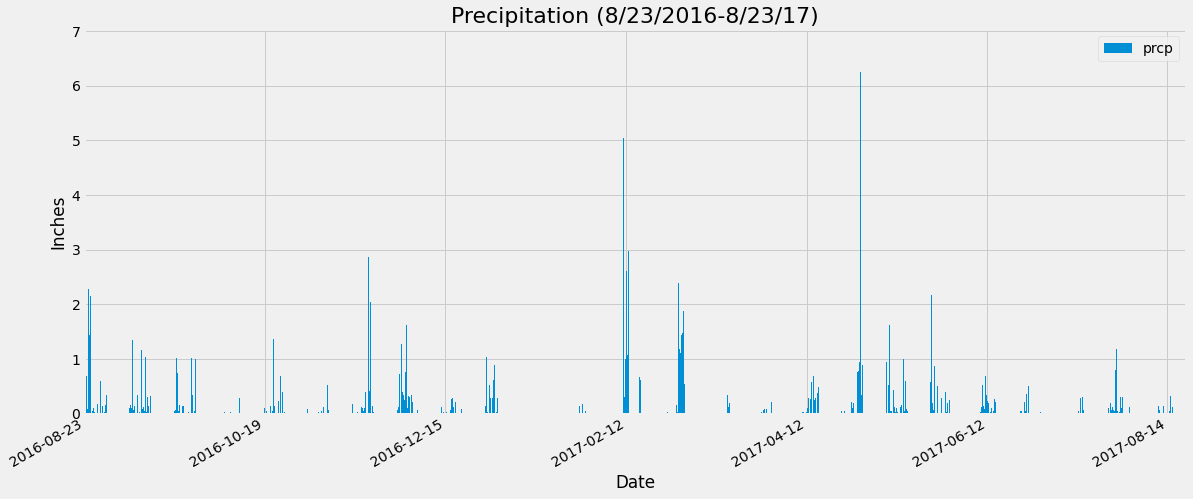

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
end_date = dt.date(2017, 8, 23)
start_date = end_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
year_precip = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date.between(start_date, end_date))\
    .all()

# Save the query results as a Pandas DataFrame and set the index to the date column
year_precip_df = pd.DataFrame(year_precip)

# Sort the dataframe by date
year_precip_df.sort_values('date', inplace=True)
# year_precip_df.head(25)

# Use Pandas Plotting with Matplotlib to plot the data
year_precip_df.set_index('date', inplace=True)
year_precip_df.plot(kind='bar', figsize=(16,7))
plt.tight_layout()
plt.title("Precipitation (8/23/2016-8/23/17)", fontsize=22)
plt.xlabel("Date")
plt.ylabel("Inches")
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=1))
plt.gcf().autofmt_xdate() # Rotation
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
station_names = session.query(Station.station).all()
print(station_names)

[('USC00519397',), ('USC00513117',), ('USC00514830',), ('USC00517948',), ('USC00518838',), ('USC00519523',), ('USC00519281',), ('USC00511918',), ('USC00516128',)]


In [15]:
# Design a query to calculate the total number stations in the dataset
# station_analysis = session.query(Station.station).all()
num_stations = session.query(Station.station).count()
print(f"There are {num_stations} stations in the dataset")

There are 9 stations in the dataset


In [16]:
station_analysis = session.query(Measurement.date, Measurement.station).all()
station_analysis_df = pd.DataFrame(station_analysis)
station_analysis_df.head()

,date,station
0,2010-01-01,USC00519397
1,2010-01-02,USC00519397
2,2010-01-03,USC00519397
3,2010-01-04,USC00519397
4,2010-01-06,USC00519397


In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_active_df = station_analysis_df.groupby("station").count().sort_values(by=["date"], ascending=False)
station_active_df = station_active_df.rename(columns={"date" : "station count"})
station_active_df

,station count
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

temp_min_USC00519281 = session.query(func.min(Measurement.tobs).\
                                     filter(Measurement.station == "USC00519281").\
                                     label('USC00519281 MIN')
                                    )

temp_max_USC00519281 = session.query(func.max(Measurement.tobs).\
                                     filter(Measurement.station == "USC00519281").\
                                     label('USC00519281 MAX')
                                    )

temp_avg_USC00519281 = session.query(func.avg(Measurement.tobs).\
                                     filter(Measurement.station == "USC00519281").\
                                     label('USC00519281 AVG')
                                    )
print(f"The minimum temperature for Station USC00519281 was {temp_min_USC00519281.all()}")
print(f"The maximum temperature for Station USC00519281 was {temp_max_USC00519281.all()}")
print(f"The average temperature for Station USC00519281 was {temp_avg_USC00519281.all()}")

The minimum temperature for Station USC00519281 was [(54.0,)]
The maximum temperature for Station USC00519281 was [(85.0,)]
The average temperature for Station USC00519281 was [(71.66378066378067,)]


In [19]:
session.query(Measurement.station, Measurement.date).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date.desc()).first()

('USC00519281', '2017-08-18')

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

USC00519281_end_date = dt.date(2017, 8, 18)
USC00519281_start_date = end_date - dt.timedelta(days=365)

USC00519281_temp_analysis = session.query(Measurement.station, Measurement.tobs, Measurement.date).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date.between(USC00519281_start_date, USC00519281_end_date)).\
    all()

USC00519281_temp_analysis_df = pd.DataFrame(USC00519281_temp_analysis)
USC00519281_temp_analysis_df

,station,tobs,date
0,USC00519281,77.0,2016-08-23
1,USC00519281,77.0,2016-08-24
2,USC00519281,80.0,2016-08-25
3,USC00519281,80.0,2016-08-26
4,USC00519281,75.0,2016-08-27
...,...,...,...
347,USC00519281,77.0,2017-08-14
348,USC00519281,77.0,2017-08-15
349,USC00519281,76.0,2017-08-16
350,USC00519281,76.0,2017-08-17


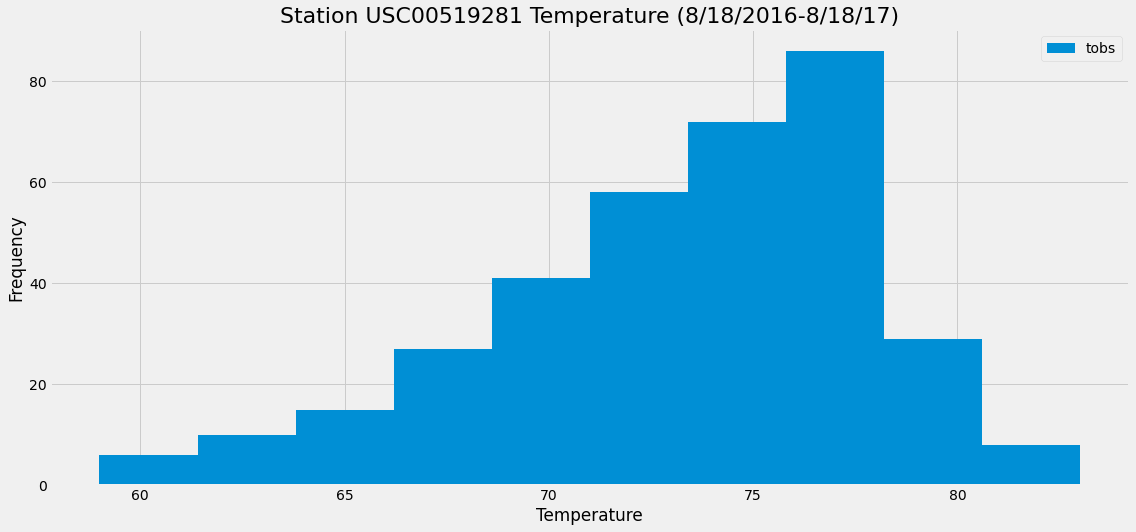

In [21]:
# plot the results as a histogram
USC00519281_temp_analysis_df.plot(kind='hist', figsize=(16,7))
plt.tight_layout()
plt.title("Station USC00519281 Temperature (8/18/2016-8/18/17)", fontsize=22)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close session

In [22]:
# Close Session
session.close()